# Check data from hubs

This notebook is intended for testing data integrity and quality. We use it for checking data from new version of the badges (hardware or firmware), and we look mainly for:
1. Gaps in the data. Thre shouldn't be gaps in the data, at least until the badge starts to reset because of low voltage
2. Battery life. We look at the voltage and see how fast it drops.

In [24]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import pytz
import gzip

# Import the data analysis tools
import openbadge_analysis as ob
import openbadge_analysis.preprocessing
import openbadge_analysis.core

In [7]:
# Settings
time_zone = 'US/Eastern' # Your local timezone
hublog_time_zone = 'UTC'
log_version = '2.0'
time_bins_size = '60S'

proximity_filename = '../data/raw/20171201_badge_test_accel/proximity_archive.txt.gz'
audio_filename = '../data/raw/20171201_badge_test_accel/audio_archive.txt.gz'
hublog_filename = '../data/raw/20171201_badge_test_accel/hub.log.gz'

In [39]:
# enables the %%R magic, not necessary if you've already done this
import readline
%load_ext rpy2.ipython 

%R -i time_zone timezone <- time_zone; print(timezone)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


[1] "US/Eastern"


In [54]:
%%R
library(ggplot2)
library(scales)
rh_theme = theme(
        panel.grid.major.x=element_blank(), #no gridlines
        panel.grid.minor.x=element_blank(), 
        panel.grid.major.y=element_blank(), 
        panel.grid.minor.y=element_blank(),
        panel.background=element_rect(fill="white"), # background=white
        axis.text.x = element_text(angle=90, hjust = 1,vjust=1,size = 4,face = "bold"),
        axis.text.y = element_text(size = 4))

# Load data

In [3]:
print("Loading sync data")
with gzip.open(hublog_filename, 'r') as f:
    syncs = ob.preprocessing.hublog_syncs(f, log_tz = hublog_time_zone, tz=time_zone)

print("Loading voltage data (from proximity records)")
with gzip.open(proximity_filename, 'r') as f:
    voltages = ob.preprocessing.voltages(f, time_bins_size, tz=time_zone)


Loading sync data
Loading voltage data (from proximity records)


In [26]:
voltages.head()

datetime                   member    
2017-12-01 15:51:00-05:00  6RWVIQQGHB    3.16
                           YRHSDROVRV    3.15
2017-12-01 15:52:00-05:00  YRHSDROVRV    3.13
2017-12-01 15:54:00-05:00  6RWVIQQGHB    3.11
                           YRHSDROVRV    3.07
Name: voltage, dtype: float64

# Voltage

In [67]:
# Down sample
voltages_down = voltages.groupby([pd.TimeGrouper('300S', level='datetime'), 'member']).mean()

In [70]:
# switch to relative time (since experiment started)
first_date = voltages_down.index.get_level_values('datetime').min()
voltages_realtive_time = voltages_down.reset_index().copy()
voltages_realtive_time['datetime'] = voltages_realtive_time['datetime'] - first_date
voltages_realtive_time['day'] = voltages_realtive_time['datetime']/pd.Timedelta(days=1)

In [75]:
print(voltages_realtive_time.dtypes)
voltages_realtive_time.head()

datetime    timedelta64[ns]
member               object
voltage             float64
day                 float64
dtype: object


,datetime,member,voltage,day
0,00:00:00,6RWVIQQGHB,3.135000,0.000000
1,00:00:00,YRHSDROVRV,3.116667,0.000000
2,00:05:00,6RWVIQQGHB,3.090000,0.003472
3,00:05:00,YRHSDROVRV,3.024000,0.003472
4,00:10:00,6RWVIQQGHB,3.052000,0.006944


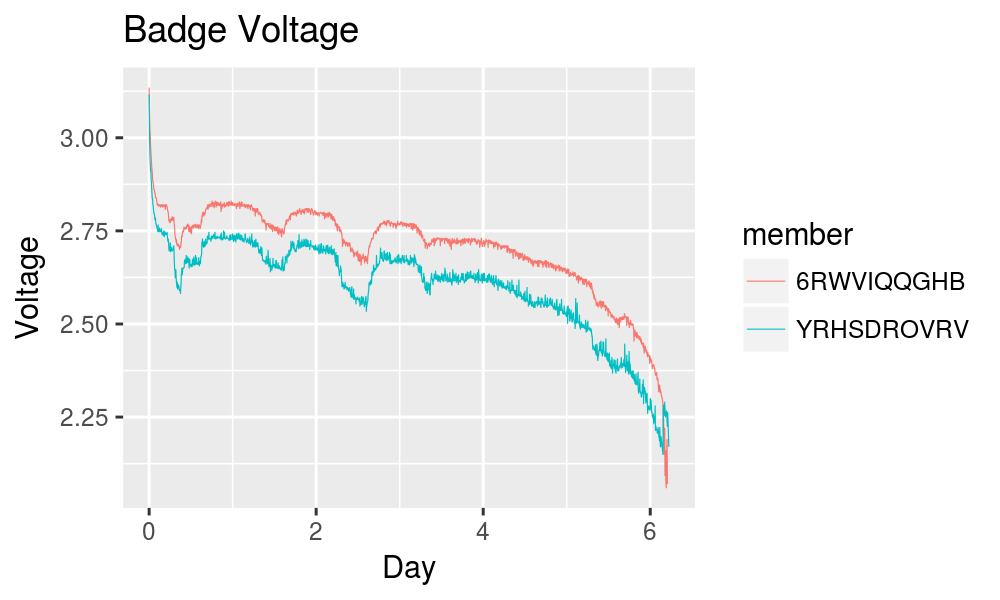

In [117]:
%%R -i voltages_realtive_time -w 5 -h 3 --units in -r 200
data <- voltages_realtive_time
#data$datetime <- as.POSIXct(data$datetime, tz = timezone)

ggplot(data, aes(x = day, y = voltage, color =member)) +
    geom_line(size=0.2) +
    labs(title="Badge Voltage", x="Day", y="Voltage")
    #rh_theme